# COVID-19 Research Paper K-Means Clustering

Create clusters in the data using the abstracts of each paper, using the K-means clustering algorithm.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import nltk
from nltk.stem.snowball import SnowballStemmer

import re

In [2]:
"""Convert metadata.csv to a df_abstracts, which contains the sha and abstracts of every valid paper.
-read in metadata.csv to a df
-filter out rows without a full text file
-filter out rows with multiple corresponding full text files
-create df_abstracts, which contains sha and abstracts for all valid papers
"""

df = pd.read_csv("CORD-19-research-challenge/metadata.csv")
df_with_full = df.loc[df['has_full_text'] == True].drop(columns = 'has_full_text')

df_custom_license = df_with_full.loc[df_with_full['full_text_file'].str.match("custom_license")]
df_noncomm_use_subset = df_with_full.loc[df_with_full['full_text_file'].str.match("noncomm_use_subset")]
df_comm_use_subset = df_with_full.loc[df_with_full['full_text_file'].str.match("comm_use_subset")]
df_biorxiv_medrxiv = df_with_full.loc[df_with_full['full_text_file'].str.match("biorxiv_medrxiv")]

invalid_rows = []
for index, row in df_custom_license.iterrows():
    if ";" in row['sha']:
        invalid_rows.append(index)

df_custom_license = df_custom_license.drop(invalid_rows)

invalid_rows = []
for index, row in df_noncomm_use_subset.iterrows():
    if ";" in row['sha']:
        invalid_rows.append(index)
        
df_noncomm_use_subset = df_noncomm_use_subset.drop(invalid_rows)

invalid_rows = []
for index, row in df_comm_use_subset.iterrows():
    if ";" in row['sha']:
        invalid_rows.append(index)
        
df_comm_use_subset = df_comm_use_subset.drop(invalid_rows)

invalid_rows = []
for index, row in df_biorxiv_medrxiv.iterrows():
    if ";" in row['sha']:
        invalid_rows.append(index)
        
df_biorxiv_medrxiv = df_biorxiv_medrxiv.drop(invalid_rows)

df_all = pd.concat([df_custom_license, df_noncomm_use_subset, df_comm_use_subset, df_biorxiv_medrxiv])

df_abstracts = df_all[['sha','abstract']]

df_abstracts.to_csv("abstracts.csv")

In [3]:
"""Take sample of rows from df_abstracts to reduce runtime"""

df_abstracts_partial = df_abstracts.sample(n=10000)
df_abstracts_partial = df_abstracts_partial.dropna()

In [4]:
"""Remove rows with bad input in abstract column"""

abstract_list = df_abstracts_partial["abstract"].values
abstract_list = [x for x in abstract_list if str(x) != 'nan']
type(abstract_list)

list

In [5]:
"""Check to make sure all abstract values are strings"""

bad_inputs = 0
for i in abstract_list:
    if type(i) != str:
        bad_inputs += 1
bad_inputs

0

In [6]:
""" Takes in abstract_list, returns abstract_list_stemmed, which contains the same list
of strings but with each word converted to reduce variability
"""

snowBallStemmer = SnowballStemmer("english")

abstract_list_stemmed = []

# adapted from http://jonathansoma.com/lede/algorithms-2017/classes/more-text-analysis/counting-and-stemming/
def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [snowBallStemmer.stem(word) for word in words]
    return words

for i in abstract_list:
    words_list = stemming_tokenizer(i)
    words_paragraph = ""
    for j in words_list:
        words_paragraph = words_paragraph + " " + j
    abstract_list_stemmed.append(words_paragraph)

In [7]:
"""Creares a df of TFIDF vectorized abstracts

TF-IDF (term frequency-inverse document frequency) is a statistical
measure that evaluates how relevant a word is to a document in a collection.

adapted from https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76

token_pattern=r'(?u)\b[A-Za-z]+\b' filters out non-alphabetical characters
"""

vectorizer = TfidfVectorizer(min_df = 10, max_df = 0.8, max_features = 150, stop_words = 'english', token_pattern=r'(?u)\b[A-Za-z]+\b')
vectors = vectorizer.fit_transform(abstract_list_stemmed)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)
df.head()

,abstract,acid,activ,acut,addit,age,analysi,anim,antibodi,antigen,...,test,time,transmiss,treatment,type,use,vaccin,viral,virus,year
0,0.000000,0.0,0.000000,0.482352,0.082205,0.000000,0.0,0.088546,0.000000,0.000000,...,0.0,0.081158,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.051346,0.0,0.000000,0.000000,0.000000,0.090229,0.0,0.000000,0.000000,0.090776,...,0.0,0.000000,0.0,0.0,0.159374,0.091659,0.313177,0.000000,0.136044,0.0
2,0.000000,0.0,0.154535,0.000000,0.000000,0.000000,0.0,0.000000,0.195288,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.264222,0.000000,0.0
3,0.000000,0.0,0.000000,0.118764,0.000000,0.000000,0.0,0.392430,0.135894,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.091931,0.286955,0.0
4,0.056655,0.0,0.075005,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [8]:
"""Apply PCA to normalized TF-IDF document vectors to reduce number of dimensions to help with K-means clustering.
Used a threshold value of 0.85 to ensure the reduced dimension vectors account for 85% of the variance."""

# adapted from https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components = 0.85)
standardized_values = StandardScaler().fit_transform(df.values)
principal_components = pca.fit_transform(standardized_values)
reduced_df = pd.DataFrame(data = principal_components)
reduced_df

,0,1,2,3,4,5,6,7,8,9,...,103,104,105,106,107,108,109,110,111,112
0,4.124396,-1.916034,-0.911784,-2.171100,1.345043,-0.755137,0.840342,-2.402296,-0.146405,-1.325705,...,-0.008581,0.795748,1.203686,1.461613,-0.145785,0.927200,-2.902187,0.265435,0.990699,1.099964
1,-0.009050,-0.776096,0.608037,0.765852,-1.710224,2.720914,-1.388677,-0.155083,0.667554,-1.811394,...,0.007782,-0.679332,-0.329040,-0.077057,0.684506,-1.193105,-0.467741,-0.774906,0.599267,-0.790632
2,-3.088882,1.885717,0.812144,-1.597569,-2.511830,-1.461036,0.514422,-0.687022,-0.791450,-0.991470,...,1.611554,-1.494348,0.410457,0.187741,-0.004521,0.030054,0.431359,-0.259019,-0.160919,0.274608
3,0.054034,0.188531,5.272706,-1.723879,1.631993,1.109986,1.156794,0.815815,-2.656601,-0.879498,...,0.030657,0.085331,1.156129,0.703353,1.479799,0.969354,-0.223972,0.056237,0.937590,0.786549
4,1.533950,3.407465,0.479368,0.110411,-0.601432,-0.011116,-0.003831,-1.474597,1.705342,3.224137,...,0.066476,0.394371,0.104302,0.387438,-0.140383,-1.136747,-0.103257,-0.454013,1.090185,-0.297241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8716,-2.874024,-0.084626,-1.695707,-2.575094,-0.937536,3.347025,-0.596767,-0.732483,0.215316,0.569673,...,0.125105,-0.921821,0.868176,-0.739677,0.198532,-0.000779,-1.012744,-0.105149,-0.104457,-0.414159
8717,0.816910,1.168550,-1.279006,0.384240,-0.913869,2.376515,-2.110601,1.002456,-1.236614,-1.867895,...,-0.587531,1.230283,-1.614747,-0.171988,1.522222,-0.537089,-1.374349,-1.317184,-1.818927,-0.044132
8718,-2.374566,-1.350541,-1.137618,-0.228089,-0.292696,1.259559,-1.287866,-0.167597,0.991976,-0.274117,...,0.228758,-0.601299,-0.387695,0.131499,-0.131777,0.604900,0.725940,0.478404,-1.222611,0.218180
8719,2.149913,-1.169172,-2.430630,-3.226069,-0.457731,-1.396046,0.120696,0.081579,-1.614508,-0.508711,...,0.358407,-0.822057,-1.317649,-1.313123,1.745488,-0.248960,-1.953376,-1.141538,0.567553,0.697447


In [9]:
"""100 most relevant features"""

(reduced_df.columns)

RangeIndex(start=0, stop=113, step=1)

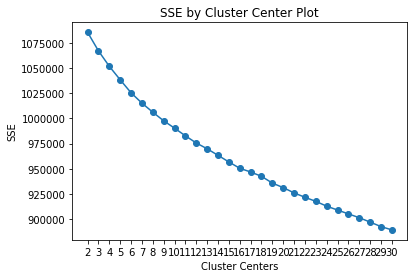

In [10]:
"""Creates an elbow plot to identify the ideal number of clusters based on sum of squared errors

copied from https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans
"""

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1)
    
    sse = []
    for k in iters:
        sse.append(KMeans(n_clusters=k, n_init=20).fit(data).inertia_)
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(reduced_df, 30)

In [11]:
"""Displays an example of the TFIDF vector for a single paper"""

row_dict = df.loc[ 0 , : ].to_dict()

from collections import OrderedDict

dd = OrderedDict(sorted(row_dict.items(), key=lambda x: x[1], reverse=True))
dd

OrderedDict([('acut', 0.4823523112360362),
             ('clinic', 0.446283441670686),
             ('group', 0.4306022497315595),
             ('p', 0.28856806393052953),
             ('compar', 0.23212066698156011),
             ('n', 0.1862970749988464),
             ('risk', 0.17954048557242147),
             ('requir', 0.17863783795059432),
             ('relat', 0.16256785965295578),
             ('care', 0.10351625545590837),
             ('rate', 0.09057779154695153),
             ('respect', 0.08965673574144675),
             ('non', 0.08870986389385019),
             ('anim', 0.0885460063310952),
             ('common', 0.08838309138657106),
             ('addit', 0.08220481148866626),
             ('time', 0.08115778275929604),
             ('background', 0.0794680560066313),
             ('present', 0.0744467031684074),
             ('control', 0.07382462101682984),
             ('conclus', 0.07234205693137935),
             ('import', 0.07109454428922854),
             ('s

In [12]:
"""Adds assigned cluster cloumn to df_partial_abstracts."""

clusters = KMeans(n_clusters=14).fit_predict(df)

df_abstracts_partial["cluster"] = clusters
df_abstracts_partial.sort_values("cluster")

,sha,abstract,cluster
22043,0a4ff36a0de0c6c9efdcc2f20e3223a31e4c05a0,BACKGROUND: Human bocavirus is a newly discove...,0
27166,11a6f813fa996f0baa670ecc66875602f971eef1,Severe combined immunodeficiency (SCID) is cha...,0
39676,26f1c42474966b8daede2912e06175bd8b864f8e,The development of molecular syndrome-based ki...,0
14272,8bb0b0ba65268a27dfb2ecd6591fd970e3204371,Abstract Objectives Regulatory cytokines are a...,0
7335,dd2c00500df2400fe1aaf280c35ca3ffa2854fb3,Background Previous studies support a strong a...,0
...,...,...,...
27648,7b0abf2414de3794e54ed37050884f636333972f,To better track public health events in areas ...,13
26557,9816051343f6acf13246fd5957e876a4db2c1ab7,BACKGROUND: Data on grants for biomedical rese...,13
19480,c82d59add457527b2858fb5157a92634815d9387,The recent revision of the International Healt...,13
20331,aad82670f39f4f9731dfeab9064d1063d13c5cb8,Public health surveillance is undergoing a rev...,13


In [13]:
clustercounts = df_abstracts_partial[["abstract", "cluster"]]
clustercounts = clustercounts.groupby("cluster", as_index=False).count().sort_values("cluster", ascending=True)
clustercounts

,cluster,abstract
0,0,699
1,1,609
2,2,385
3,3,547
4,4,814
5,5,1514
6,6,617
7,7,641
8,8,451
9,9,919


([<matplotlib.axis.XTick at 0x1a1e8d6650>,
 <a list of 14 Text xticklabel objects>)

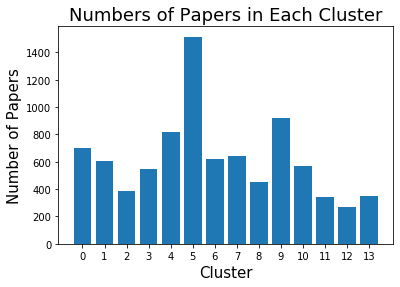

In [14]:
# plt.figure(figsize=(10,6))
# bar plot with matplotlib
plt.bar('cluster', 'abstract', data=clustercounts)
plt.xlabel("Cluster", size=15)
plt.ylabel("Number of Papers", size=15)
plt.title("Numbers of Papers in Each Cluster", size=18)
plt.xticks(clustercounts["cluster"].values)

In [15]:
"""Use t-SNE to reduce the >100 dimensional points to two dimensions."""

from sklearn.manifold import TSNE

tsne_results = TSNE(n_components=2).fit_transform(reduced_df)

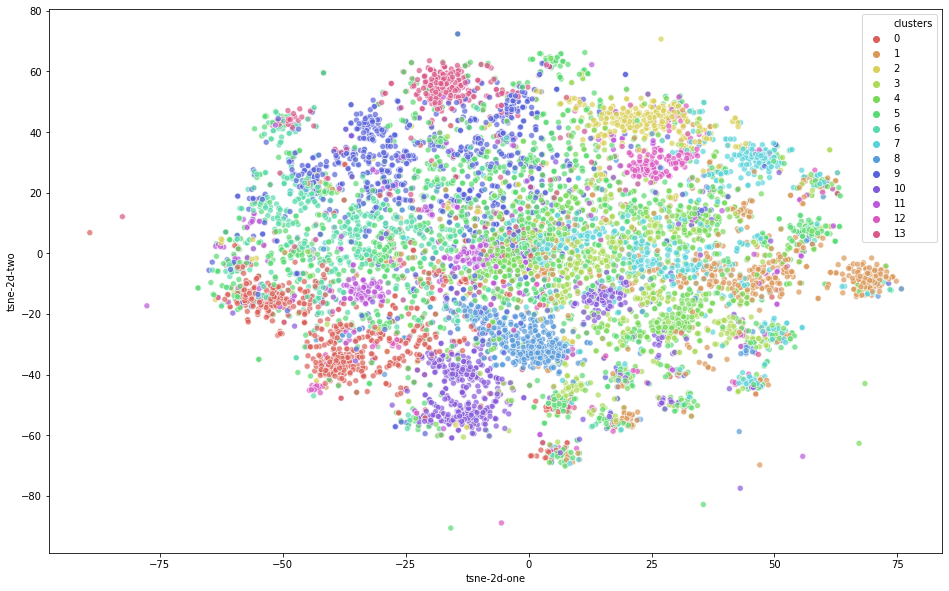

In [16]:
"""Use the results of t-SNE to visualize the clusters on a two dimensional plot."""

# adapted from https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

df_tsne = pd.DataFrame()

df_tsne['tsne-2d-one'] = tsne_results[:,0]
df_tsne['tsne-2d-two'] = tsne_results[:,1]
df_tsne["clusters"] = clusters

plt.figure(figsize=(16,10))
sns.scatterplot(
    x='tsne-2d-one',
    y='tsne-2d-two',
    data=df_tsne,
    palette=sns.color_palette("hls", 14),
    legend="full",
    alpha=0.7,
    hue="clusters"
)

In [17]:
# The sample of papers with their assigned clusters
df_abstracts_partial

,sha,abstract,cluster
43950,543ac2431685616436dfe9f7ff063a02a741686f,BACKGROUND: Acute diarrhea is a common clinica...,5
12141,ecaf79f129ccf48802f4d33a002c6d9d207ea220,"Abstract Since 2009, strains of the naturally ...",10
21042,f4f75af02b7226c5b2363de1a75821a4b9b20412,The immune response against some viral pathoge...,1
28652,e065a96a33ccdbcc23e9f7d0af9c5edf440cb478,An outbreak of severe acute respiratory syndro...,8
2971,29490fd3aab6d6a58577a78e0f572669cb95cbc6,Abstract The field of public health includes a...,13
...,...,...,...
25391,e0393328e9f59159671bff8a33e26edbdab28034,Sustained adaptive immunity to pathogens provi...,7
22067,4d392425fe3005f145fdfa835421ff0aa5fe0104,"Passive immunity (PI), acquired through colost...",9
26633,c4a46bccbf43ff75b7e20f5081f3c5b7a31b7b29,C57 BL/6N mice injected intracranially with th...,7
27745,f3725ca2fdaeaaf188c63878e4c6263408e52aa2,BACKGROUND: Major hurdles for survival after l...,6
